# Autoencoder

Un modelo de autoencoder se descompone a su vez en dos modelos de redes neuronales. La primera, el encoder, tiene el objetivo de comprimir la información de los datos; la segunda, el decoder, trata de reconstruir la información original a partir de los datos comprimidos. 

La motivación para el estudio de un encoder en este problema es:
1. Una vez entrenado el autoencoder completo, podemos separar las dos redes neuronales subyacentes y utilizar la parte encoder (con alguna modificación) para probar su rendimiento como modelo de red de clasificación.
2. Para los datos de test proporcionados por la competición de Kaggle (no se dispone de la clasificación verdadera), el encoder puede ayudar a "recrear" sus etiquetas.

### Preparación de los datos

In [1]:
# Estructuras de datos
import pandas as pd
import numpy as np
# Data partition
from sklearn.model_selection import train_test_split
# Parameter tunning libraries
import optuna
from sklearn.model_selection import GridSearchCV
# Accuracy function
from sklearn.metrics import accuracy_score
# Model
import tensorflow as tf
import keras
from keras import layers, models

In [2]:
# Datos de entrenamiento
trainFNC = pd.read_csv("../data/train_FNC.csv")
trainSBM = pd.read_csv("../data/train_SBM.csv")
train_labels = pd.read_csv("../data/train_labels.csv")

# DataFrame con ambas fuentes de datos
train = pd.merge(left=trainFNC, right=trainSBM, left_on="Id", right_on="Id")
data = pd.merge(left=train_labels, right=train, left_on="Id", right_on="Id")
data.drop("Id", inplace=True, axis=1)

# Shuffle de los datos de train
data = data.sample(frac=1, random_state=0)
data.head(5)

,Class,FNC1,FNC2,FNC3,FNC4,FNC5,FNC6,FNC7,FNC8,FNC9,...,SBM_map55,SBM_map61,SBM_map64,SBM_map67,SBM_map69,SBM_map71,SBM_map72,SBM_map73,SBM_map74,SBM_map75
2,0,0.245850,0.216620,-0.124680,-0.353800,0.161500,-0.002032,-0.133020,-0.035222,0.259040,...,-0.257114,0.597229,1.220756,-0.059213,-0.435494,-0.092971,1.090910,-0.448562,-0.508497,0.350434
13,1,0.410730,-0.031925,0.210700,0.242260,0.320100,-0.419290,-0.187140,0.168450,0.599790,...,-0.050862,0.870602,0.609465,1.181878,-2.279469,-0.013484,-0.012693,-1.244346,-1.080442,-0.788502
53,1,0.070919,0.034179,-0.011755,0.019158,0.024645,-0.032022,0.004620,0.318170,0.212550,...,-1.539922,-1.495822,1.643866,1.687780,1.521086,-1.988432,-0.267471,0.510576,1.104566,-1.067206
41,0,0.087377,-0.052462,-0.007835,-0.112830,0.389380,0.216080,0.063572,-0.251230,-0.080568,...,-0.077353,-0.459463,-0.204328,-0.619508,-1.410523,-0.304622,-1.521928,0.593691,0.073638,-0.260920
74,0,0.202750,0.191420,-0.056662,-0.157780,0.244040,0.039780,-0.001503,0.001056,-0.048222,...,0.044457,0.593326,1.063052,0.434726,1.604964,-0.359736,0.210107,0.355922,0.730287,-0.323557


Vamos a usar la siguiente partición de los datos:

* 60% train $\sim$ 50 datos
* 20% validation $\sim$ 18 datos (se define al aplicar cross-validación en el ajuste)
* 20% test $\sim$ 18 datos

In [3]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Tamaño del dataset de train:", X_train.shape)
print("Tamaño del dataset de test:", X_test.shape)

Tamaño del dataset de train: (68, 410)
Tamaño del dataset de test: (18, 410)


In [4]:
# Datos de test
testFNC = pd.read_csv("../data/test_FNC.csv")
testSBM = pd.read_csv("../data/test_SBM.csv")

# DataFrame con ambas fuentes de datos
test_kaggle = pd.merge(left=testFNC, right=testSBM, left_on="Id", right_on="Id")
test_kaggle.drop("Id", inplace=True, axis=1)
test_kaggle.head(5)

,FNC1,FNC2,FNC3,FNC4,FNC5,FNC6,FNC7,FNC8,FNC9,FNC10,...,SBM_map55,SBM_map61,SBM_map64,SBM_map67,SBM_map69,SBM_map71,SBM_map72,SBM_map73,SBM_map74,SBM_map75
0,0.476127,0.064466,0.053238,-0.608133,0.073988,-0.637038,0.113556,-0.192434,-0.004025,-0.060474,...,-0.451994,1.123770,2.083006,1.145440,-0.067608,1.202529,0.851587,0.451583,-0.159739,0.192076
1,0.013833,0.267183,0.232178,-0.167151,-0.261327,0.191869,0.406493,0.088761,0.177048,0.036718,...,0.696987,1.397832,1.046136,-0.191733,-2.192023,-0.369276,0.822225,-0.109342,-0.580476,0.174160
2,-0.435452,0.046780,0.243742,0.397030,-0.147821,0.173620,-0.461963,-0.610736,0.419753,0.400985,...,0.160145,1.906989,-2.661633,-0.193911,0.440873,0.641739,0.918397,-0.758046,0.154701,-0.476647
3,-0.204510,-0.036735,-0.760705,-0.740495,0.064668,0.349926,-0.273826,-0.174384,-0.120248,0.175618,...,0.974828,-1.997087,-2.083782,1.154107,-0.643947,2.332424,0.659124,-0.809445,0.558960,2.790871
4,0.599435,-0.166441,0.122431,0.011539,0.346906,-0.017430,-0.274734,0.211510,0.151012,-0.033434,...,-0.789153,1.578984,1.402592,-1.230440,0.296686,2.806314,0.427184,-0.240682,-0.196948,-1.544345


### Modelo

Para crear el autoencoder, se utilizarán redes simétricas.

In [30]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer = layers.Input(shape=(410,))
# Capas red encoder
encoded = layers.Dense(200, activation="linear")(input_layer)
encoded = layers.Dense(100, activation="linear")(encoded)
encoded = layers.Dense(50, activation="linear")(encoded)
# Capas red decoder
decoded = layers.Dense(50, activation="linear")(encoded)
decoded = layers.Dense(100, activation="linear")(decoded)
decoded = layers.Dense(200, activation="linear")(decoded)
decoded = layers.Dense(410)(decoded)

# Encoder
encoder = models.Model(input_layer, encoded)

# Autoencoder
autoencoder = models.Model(input_layer, decoded)

# Compilar y entrenar el autoencoder
autoencoder.compile(optimizer="rmsprop", loss="mse")
# autoencoder.fit(test_kaggle, test_kaggle, epochs=100, batch_size=64, validation_split=0.25)
autoencoder.fit(test_kaggle[:10], test_kaggle[:10], epochs=1000, batch_size=64, validation_split=0, verbose=0)

In [7]:
autoencoder.save("autoencoder.h5")

In [5]:
autoencoder = models.load_model("autoencoder.h5")

Evaluación del autoencoder, se utilizarán métricas como:

* MSE = $\frac{1}{n} \sum_{i=1}^{n} (Y_{true}^{i} - Y_{pred}^{i})^{2}$
* MAPE = $\frac{1}{n} \sum_{i=1}^{n} \left| \frac{Y_{true}^{i} - Y_{pred}^{i}}{Y_{true}^{i}} \right|$

donde $Y_{true}$ es el valor real, $Y_{pred}$ el valor de la predicción y $n$ el número de predicciones.

La anterior fórmula realiza el cálculo para dos "listas de valores", por ejemplo, podemos calcular el error MAPE por muestra o por feature. Para el valor del error de la predicción total, se debe promediar el error obtenido para todas las filas/columnas.

In [59]:
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError

# Definición de las métricas
mse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mape = MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

In [63]:
# ERROR SOBRE X_train (etiquetados)

X_train_pred = autoencoder.predict(X_train)
print("MAPE:", mape(X_train, X_train_pred))


# print("Mean squared error in X_train data prediction:", mse(X_train, X_train_pred).numpy())
# sum(abs((test.to_numpy()[:, 0] - test_pred[:, 0]) / test.to_numpy()[:, 0])) * (100 / len(test_pred[:, 0]))

MAPE: tf.Tensor(346.17618, shape=(), dtype=float32)


In [8]:
dims = X_train_pred.shape

mape_list = np.empty((410))

# El bucle calcula el MAPE por cada columna
for i in range(dims[1]):
    mape_list[i] = sum(abs((X_train.iloc[:, i] - X_train_pred[:, i]) / X_train.iloc[:, i])) / dims[0]
    
# 1/N ~ 1/(longitud de cada columna) = 1/(nº de filas)
# mape_list.mean() * (100 / dims[0])
mape_list

268.1136737291194

In [67]:
Xt_tmp =  X_train
# Xt_tmp =  test_kaggle[:10]

Xp_tmp =  autoencoder.predict(Xt_tmp)

mape_tmp = np.abs((Xt_tmp - Xp_tmp) / Xt_tmp)
    
# 1/N ~ 1/(longitud de cada columna) = 1/(nº de filas)
# mape_list.mean() * (100 / dims[0])
mape_tmp.shape

(68, 410)

<AxesSubplot:>

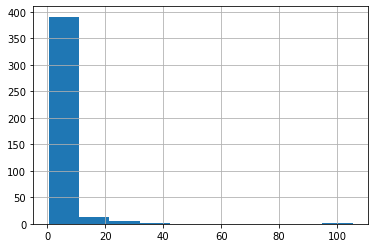

In [90]:
mape_tmp.mean(axis=0).hist()

In [91]:
(mape_tmp.mean(axis=0) < 1).mean()

0.041463414634146344

In [75]:
mape_tmp.to_numpy().sum() / 68

1419.3223672248703

In [78]:
def MAPE_(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE_(Xt_tmp.to_numpy(), Xp_tmp)

346.17618712801715

In [66]:
print("MAPE:", mape(
    Xt_tmp.to_numpy(),
    autoencoder.predict(Xt_tmp)
))

MAPE: tf.Tensor(346.17618, shape=(), dtype=float32)


In [57]:
mape

,FNC1,FNC2,FNC3,FNC4,FNC5,FNC6,FNC7,FNC8,FNC9,FNC10,...,SBM_map55,SBM_map61,SBM_map64,SBM_map67,SBM_map69,SBM_map71,SBM_map72,SBM_map73,SBM_map74,SBM_map75
0,0.105652,0.713284,0.117756,0.007909,0.261004,0.025560,0.046394,0.077519,5.384216,0.443847,...,0.041728,0.043366,0.027362,0.016941,0.946280,0.037685,0.034822,0.007316,0.106136,0.458846
1,0.905592,0.011334,0.008692,0.149755,0.015489,0.177056,0.089562,0.812193,0.266793,1.234998,...,0.174119,0.012137,0.193251,1.462902,0.020454,0.105090,0.111466,0.854434,0.039484,0.716544
2,0.003439,0.563342,0.082334,0.085693,0.079150,0.011671,0.058281,0.005805,0.054094,0.027805,...,0.319610,0.005038,0.014532,0.136801,0.079314,0.072752,0.003710,0.052331,0.199987,0.020903
3,0.072648,1.741236,0.084134,0.098497,1.268262,0.262483,0.040180,0.555057,0.414130,0.105717,...,0.102842,0.078708,0.008026,0.030085,0.055274,0.056710,0.236990,0.044356,0.200856,0.032583
4,0.041855,0.065261,0.011034,1.936107,0.079343,2.744549,0.070099,0.070784,0.289318,0.099786,...,0.009040,0.032716,0.043766,0.187252,0.305902,0.026350,0.005066,0.234740,0.224215,0.031928
5,0.111856,0.070482,0.259590,0.316117,0.170210,0.002749,1.198931,0.145355,0.048370,0.129245,...,0.073222,0.045192,0.595943,0.024438,0.244114,0.112386,0.319973,0.137131,0.184293,0.106029
6,0.161998,0.197088,0.054220,0.047310,0.248198,0.020759,0.350624,31.450700,0.037707,0.064935,...,0.051351,0.021254,6.402787,0.054551,0.084176,3.459184,0.106564,0.036843,0.219600,0.067987
7,0.086829,0.135140,0.177873,0.042072,0.094558,0.073267,0.085125,0.648491,0.059527,0.184419,...,0.218452,0.023091,1.515034,0.007845,0.033975,0.055049,0.002271,0.052644,0.045325,0.029986
8,7.486476,0.040394,0.104811,0.058178,0.065570,0.050730,0.074255,0.082521,0.010319,0.160290,...,0.335864,0.331166,0.055139,0.011705,0.909687,0.193612,0.049962,0.026795,0.023666,0.030228
9,0.099597,0.420259,0.345776,0.112386,0.153996,0.126455,0.055246,0.114718,0.283661,0.025211,...,0.002366,0.021377,0.013038,0.031167,0.035927,0.084642,0.047585,0.047887,0.371574,0.033509


In [54]:
type(Xt_tmp.to_numpy())

numpy.ndarray

In [21]:
# Comprobación: el valor debe ser el mismo por filas o por columnas (por samples o por variables)
dims = X_train_pred.shape

mape_list_row = np.empty((68))

# El bucle calcula el MAPE por cada fila
for i in range(dims[0]):
    mape_list_row[i] = sum(abs((X_train.iloc[i, :] - X_train_pred[i, :]) / X_train.iloc[i, :]))
    
# 1/N ~ 1/(longitud de cada fila) = 1/(nº de columnas)
mape_list_row.mean() * (100 / dims[1])

268.1136737291194

In [27]:
# ERROR SOBRE test_kaggle (no etiquetados)

test_kaggle_pred = autoencoder.predict(test_kaggle)
print("MAPE:", mape(test_kaggle, test_kaggle_pred))

MAPE: tf.Tensor(597.33813, shape=(), dtype=float32)


In [31]:
# ERROR SOBRE test_kaggle (no etiquetados)

test_kaggle_pred = autoencoder.predict(test_kaggle[:10])
print("MAPE:", mape(test_kaggle[:10], test_kaggle_pred))

MAPE: tf.Tensor(65.644714, shape=(), dtype=float32)


In [21]:
# ERROR SOBRE test_kaggle (no etiquetados) REDUCIDO A LAS 68 PRIMERAS SAMPLES

test_kaggle_reduc = test_kaggle.iloc[500:568, :]

y_pred_kaggle_reduc = autoencoder.predict(test_kaggle_reduc)

print("MAPE:", mape(test_kaggle_reduc, y_pred_kaggle_reduc))

MAPE: tf.Tensor(242.9066, shape=(), dtype=float32)


In [25]:
# ERROR SOBRE test_kaggle (no etiquetados) REDUCIDO A LAS 68 PRIMERAS SAMPLES

samples_num = 100
mape_samples = []

for _ in range(samples_num):
    
    args = np.random.choice(a=np.arange(0, test_kaggle.shape[0]),
                            size=68,
                           replace=False,)

    test_kaggle_reduc = test_kaggle.iloc[args, :]

    y_pred_kaggle_reduc = autoencoder.predict(test_kaggle_reduc)
    tmp_mape = mape(test_kaggle_reduc, y_pred_kaggle_reduc)
    mape_samples.append(tmp_mape)
    
#     print("MAPE:", tmp_mape)

print(f'MAPE: {np.mean(mape_samples)} +- {np.std(mape_samples)}')

MAPE: 406.34344482421875 +- 356.6924133300781


$\color{red}{\text{EL ERROR ES MAYOR EN EL CJTO. DE KAGGLE, INCLUSO EL REDUCIDO}}$

Al sumar menos registros (68 primeros de ``test_kaggle``), se suman cantidades errores comparables, aún así es mayor el error en los datos con los que se ha entrenado.

Un error de MAPE superior al 100% indica un error muy alto.

In [24]:
encoder_input = layers.Input(shape=(410,))
encoder = encoder_input
for layer in autoencoder.layers[1:4]:
    encoder = layer(encoder)
encoder = models.Model(inputs=encoder_input, outputs=encoder)

In [25]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 410)]             0         
                                                                 
 dense (Dense)               (None, 200)               82200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
Total params: 107,350
Trainable params: 107,350
Non-trainable params: 0
_________________________________________________________________


Una vez hemos entrenado la red autoencoder, el componente encoder de la misma ya contará con unos pesos entrenados con el objetivo de comprimir los datos de entrada. Por tanto, podemos considerar de manera independiente esta red encoder y volver a entrenarla como una red para clasificación, con la ventaja de que se parte de un modelo inicializado no con unos pesos aleatorios, sino unos pesos optimizados para un problema similar.

Para hacer esto es necesario añadir previamente una capa final de clasificación.

In [26]:
prev_encoder = encoder # loading the previously saved model.

new_encoder = models.Sequential()
new_encoder.add(prev_encoder)
new_encoder.add(layers.Dense(1, activation="sigmoid"))

Incluso es posible congelar los pesos de todas las capas del encoder original, ya entrenados "para un problema similar", y modificar solamente los pesos de la capa final de clasificación, utilizando los datos de train (etiquetados).

In [27]:
tf.keras.utils.set_random_seed(0)

# Congelar los pesos de todas las capas a excepción de la última
for layer in new_encoder.layers[:-1]:
    layer.trainable = False

# Entrenar el modelo
new_encoder.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
new_encoder.fit(X_train, y_train, epochs=100, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = new_encoder.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/100
2/2 [==============================] - 18s 367ms/step - loss: 0.6492 - acc: 0.6667 - val_loss: 0.8262 - val_acc: 0.5882
Epoch 2/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6411 - acc: 0.6667 - val_loss: 0.8238 - val_acc: 0.5882
Epoch 3/100
2/2 [==============================] - 0s 31ms/step - loss: 0.6352 - acc: 0.6667 - val_loss: 0.8217 - val_acc: 0.5882
Epoch 4/100
2/2 [==============================] - 0s 34ms/step - loss: 0.6305 - acc: 0.7059 - val_loss: 0.8198 - val_acc: 0.5882
Epoch 5/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6268 - acc: 0.7059 - val_loss: 0.8183 - val_acc: 0.5882
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.6231 - acc: 0.7059 - val_loss: 0.8168 - val_acc: 0.5882
Epoch 7/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6198 - acc: 0.7059 - val_loss: 0.8151 - val_acc: 0.5882
Epoch 8/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6167 - acc: 0.

Tras unas pocas iteraciones, descongelamos todas las capas y hacemos unas pocas épocas más entrenando y actualizando los pesos para el modelo completo.

In [28]:
tf.keras.utils.set_random_seed(0)

# Congelar los pesos de todas las capas a excepción de la última
for layer in new_encoder.layers[:-1]:
    layer.trainable = True

# Entrenar el modelo
new_encoder.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
new_encoder.fit(X_train, y_train, epochs=15, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = new_encoder.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/15
2/2 [==============================] - 1s 183ms/step - loss: 0.4514 - acc: 0.8235 - val_loss: 0.7365 - val_acc: 0.5294
Epoch 2/15
2/2 [==============================] - 0s 32ms/step - loss: 0.3222 - acc: 0.9020 - val_loss: 0.7682 - val_acc: 0.6471
Epoch 3/15
2/2 [==============================] - 0s 34ms/step - loss: 0.1790 - acc: 0.9608 - val_loss: 0.7514 - val_acc: 0.6471
Epoch 4/15
2/2 [==============================] - 0s 30ms/step - loss: 0.0955 - acc: 0.9804 - val_loss: 0.8395 - val_acc: 0.6471
Epoch 5/15
2/2 [==============================] - 0s 31ms/step - loss: 0.0626 - acc: 0.9804 - val_loss: 1.0120 - val_acc: 0.8235
Epoch 6/15
2/2 [==============================] - 0s 27ms/step - loss: 0.0582 - acc: 1.0000 - val_loss: 0.8894 - val_acc: 0.6471
Epoch 7/15
2/2 [==============================] - 0s 24ms/step - loss: 0.0214 - acc: 1.0000 - val_loss: 0.7721 - val_acc: 0.6471
Epoch 8/15
2/2 [==============================] - 0s 26ms/step - loss: 0.0156 - acc: 1.0000 - va

In [12]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer2 = layers.Input(shape=(410,))
# Capas red encoder
encoded2 = layers.Dense(200, activation="linear")(input_layer2)
encoded2 = layers.Dense(100, activation="linear")(encoded2)
encoded2 = layers.Dense(50, activation="linear")(encoded2)
encoded2 = layers.Dense(1, activation="sigmoid")(encoded2)

encoder2 = models.Model(input_layer2, encoded2)

# Entrenar el modelo
encoder2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
encoder2.fit(X_train, y_train, epochs=100, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = encoder2.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/100
2/2 [==============================] - 3s 421ms/step - loss: 0.9253 - acc: 0.5098 - val_loss: 0.8377 - val_acc: 0.4706
Epoch 2/100
2/2 [==============================] - 0s 32ms/step - loss: 0.5403 - acc: 0.7647 - val_loss: 0.7234 - val_acc: 0.5882
Epoch 3/100
2/2 [==============================] - 0s 24ms/step - loss: 0.2367 - acc: 0.9608 - val_loss: 0.7454 - val_acc: 0.7647
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1574 - acc: 0.9804 - val_loss: 0.7459 - val_acc: 0.7647
Epoch 5/100
2/2 [==============================] - 0s 32ms/step - loss: 0.1253 - acc: 0.9608 - val_loss: 0.8012 - val_acc: 0.8235
Epoch 6/100
2/2 [==============================] - 0s 32ms/step - loss: 0.1049 - acc: 0.9804 - val_loss: 0.7114 - val_acc: 0.6471
Epoch 7/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0666 - acc: 0.9804 - val_loss: 0.7522 - val_acc: 0.5294
Epoch 8/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0584 - acc: 1.0

2/2 [==============================] - 0s 32ms/step - loss: 7.4195e-06 - acc: 1.0000 - val_loss: 1.3863 - val_acc: 0.7059
Epoch 63/100
2/2 [==============================] - 0s 24ms/step - loss: 6.6597e-06 - acc: 1.0000 - val_loss: 1.4061 - val_acc: 0.7059
Epoch 64/100
2/2 [==============================] - 0s 32ms/step - loss: 5.8877e-06 - acc: 1.0000 - val_loss: 1.3961 - val_acc: 0.7059
Epoch 65/100
2/2 [==============================] - 0s 48ms/step - loss: 5.1211e-06 - acc: 1.0000 - val_loss: 1.4195 - val_acc: 0.7059
Epoch 66/100
2/2 [==============================] - 0s 48ms/step - loss: 4.5277e-06 - acc: 1.0000 - val_loss: 1.4312 - val_acc: 0.7059
Epoch 67/100
2/2 [==============================] - 0s 48ms/step - loss: 4.0455e-06 - acc: 1.0000 - val_loss: 1.4429 - val_acc: 0.7059
Epoch 68/100
2/2 [==============================] - 0s 40ms/step - loss: 3.5952e-06 - acc: 1.0000 - val_loss: 1.4412 - val_acc: 0.7059
Epoch 69/100
2/2 [==============================] - 0s 32ms/step - l

# Create submissions

In [ ]:
import pathlib
from datetime import datetime

def create_submission(pred, test_id=testFNC["Id"]):
    '''
    Función para generar un csv con las predicciones de un modelo para participar en la competición de Kaggle
    '''
    submissionDF = pd.DataFrame(list(zip(test_id, pred)), columns=["Id", "Probability"])
    print(submissionDF.shape) # Comprobación del tamaño, debe ser: (119748, 2)
    current_time = datetime.now().strftime("%d-%m-%Y_%Hh%Mmin")
    current_path = pathlib.Path().resolve()
    parent_path = current_path.parent
    submissionDF.to_csv(f"{parent_path}\submissions\MLSP_submission_AE_{current_time}.csv", header=True, index=False)